In [31]:
# So... need to: 
# - write optimization for E-Step
# - Estimation for M-Step
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.toy.model import PoissonNormalToy

In [33]:
Ls = [10, 25, 50, 100, 250, 500, 1000]

sigma2s = [0.01, 0.1, 0.5, 1]

mus = [4, 10, 25]


In [34]:
link = 'identity'
sigma2 = 1.0

mu = 4.0
optim_type = 'Newton'
C = 1

L = 100

model_true = PoissonNormalToy(link, mu, sigma2)
xs, lams, ns = model_true.simulate(L)

# fig, ax = plt.subplots(1,2,figsize=(10,4))
# ax[0].hist(xs, bins=20)
# ax[1].hist(ns, bins=20)


In [35]:
# xs, lams, ns = model_true.simulate(L)
sigma2_init = 1.0
model = PoissonNormalToy(link, mu, sigma2_init)
results = model.estimate_sigma2(ns, 100, optim_type, track=True, print_iter=50)


0
50


In [36]:
results['sigma2_est']

3.4110787146793626

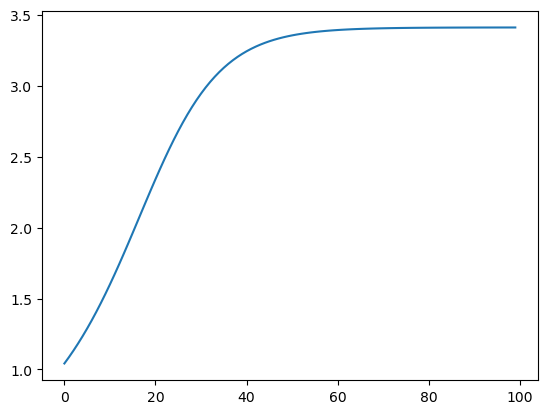

In [37]:
plt.plot(results['track']['sigma2'])

In [184]:
results['track']['sigma2'][-1]/np.pi

0.05092339000687981

In [185]:
from scipy.special import factorial
def compute_CDLL_idlink(xs, ns, mu, sigma2):
    L = xs.size
    A = (ns*np.log(xs) - xs - np.log(factorial(ns))).sum()
    B = ((xs-mu)**2).sum() / sigma2
    C = L*np.log(2*np.pi*sigma2)
    return A - (1/2)*(B + C)

def compute_GaussianLL(xs, mu, sigma2):
    L = xs.size
    B = ((xs-mu)**2).sum() / sigma2
    C = L*np.log(2*np.pi*sigma2)
    return -(1/2)*(B + C)

# poissonLL = compute_PoissonLL(ns)
def get_PoissonLL_func(ns):
    def poissonLL(lam):
        # LL = (ns*np.log(lam) - lam - np.log(factorial(ns))).sum()
        LL = (ns*np.log(lam) - lam).sum()
        return LL
    return poissonLL


In [186]:
lams = np.arange(1, 7, 0.1)
sigma2s = np.arange(0.3, 1.7, 0.01)
compute_PoissonLL = get_PoissonLL_func(ns)
gaussLL = compute_GaussianLL(xs, mu, sigma2s)
poissonLL = np.apply_along_axis(compute_PoissonLL, 0, lams[None,:])

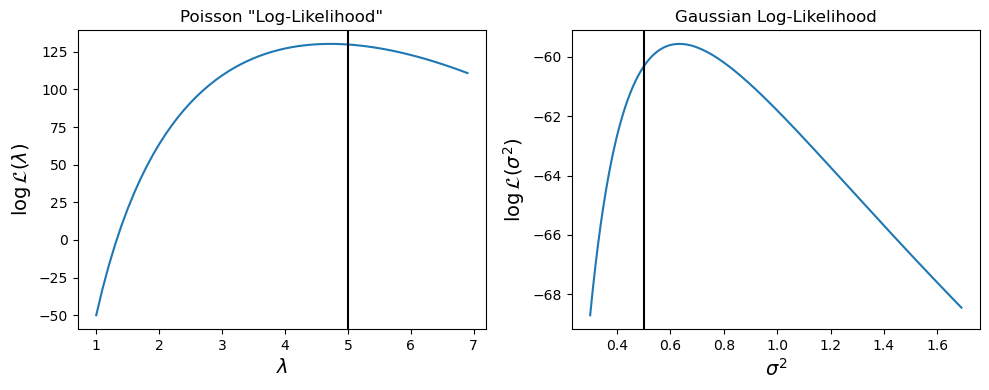

In [187]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(lams,poissonLL)
ax[0].axvline(mu, color='k')
ax[0].set_xlabel('$\\lambda$', fontweight='bold',fontsize=14)
ax[0].set_ylabel('$\log \mathcal{L} (\\lambda)$', fontweight='bold',fontsize=14)
ax[0].set_title('Poisson "Log-Likelihood"')

ax[1].plot(sigma2s,gaussLL)
ax[1].axvline(0.5, color='k')
ax[1].set_xlabel('$\\sigma^2$', fontweight='bold',fontsize=14)
ax[1].set_ylabel('$\log \mathcal{L} (\\sigma^2)$', fontweight='bold',fontsize=14)
ax[1].set_title('Gaussian Log-Likelihood')
plt.tight_layout()

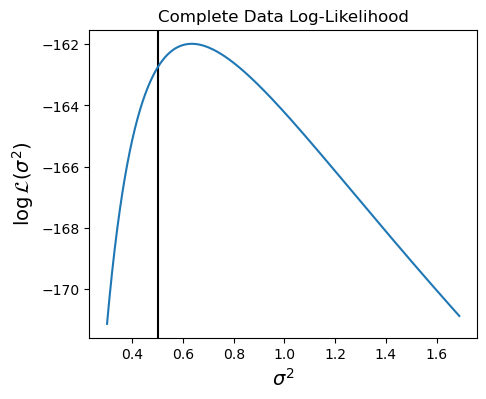

In [188]:
# Gaussian LL
cdll = compute_CDLL_idlink(xs, ns, mu, sigma2s)
fig, ax = plt.subplots(figsize=(5,4))
ax.axvline(0.5, color='k')
ax.set_xlabel('$\\sigma^2$', fontweight='bold',fontsize=14)
ax.set_ylabel('$\log \mathcal{L} (\\sigma^2)$', fontweight='bold',fontsize=14)
ax.set_title('Complete Data Log-Likelihood')
ax.plot(sigma2s, cdll)

In [189]:

r = 499
x_ests_r = track['x_ests'][:,r]

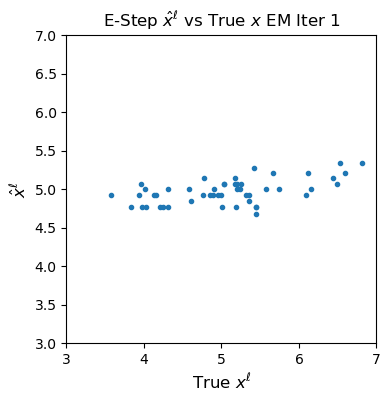

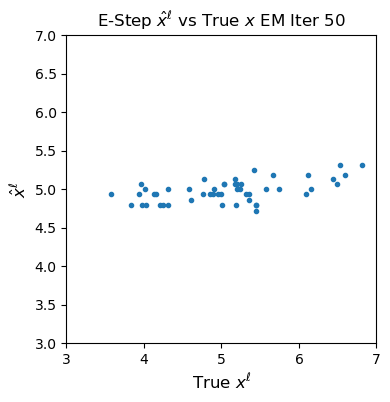

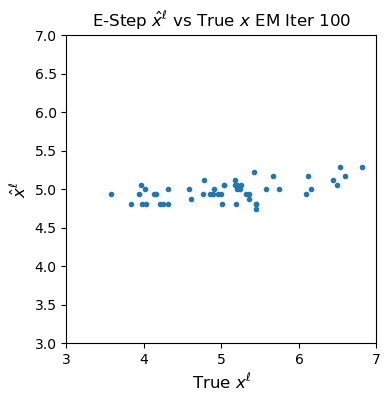

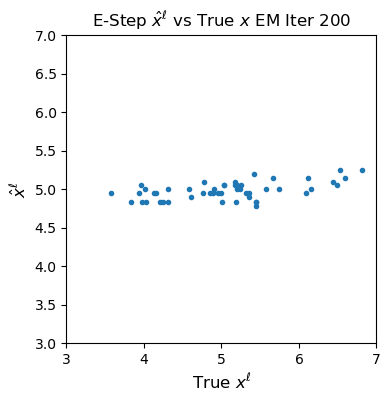

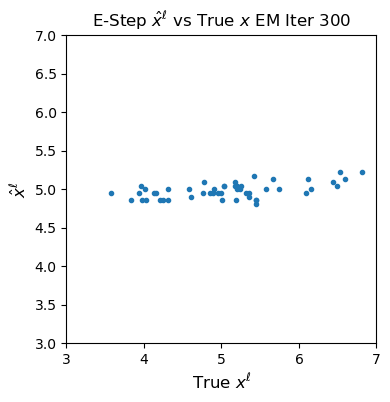

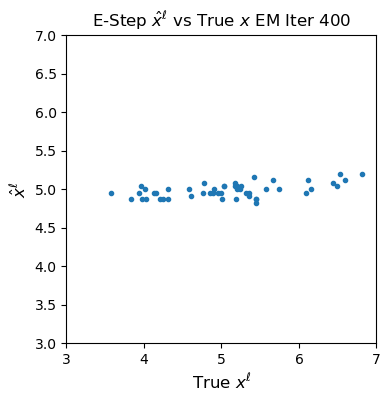

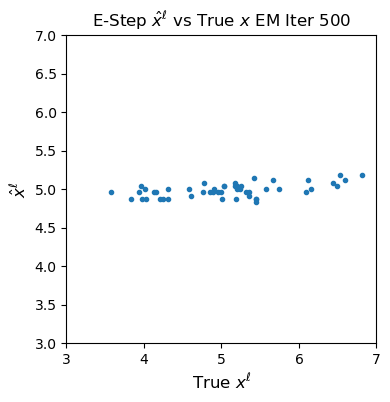

In [191]:
track = results['track']

rs = np.array([1, 50, 100, 200, 300, 400, 500]) - 1
for r in rs:
    x_ests_r = track['x_ests'][:,r]

    fig,ax = plt.subplots(figsize=(4,4))
    ax.plot(xs, x_ests_r, '.')
    ax.set_xlabel('True $x^{\\ell}$', fontsize=12)
    ax.set_ylabel('$\\hat{x}^{\\ell}$', fontsize=12)
    ax.set_title('E-Step $\\hat{x}^{\\ell}$ vs True $x$ ' + f'EM Iter {r+1}')
    ax.set_xlim([3,7])
    ax.set_ylim([3,7])

In [ ]:
track = results['track']

rs = np.array([1, 50, 100, 200, 300, 400, 500]) - 1
for r in rs:
    x_ests_r = track['x_ests'][:,r]

    fig,ax = plt.subplots(figsize=(4,4))
    ax.plot(xs, x_ests_r, '.')
    ax.set_xlabel('True $x^{\\ell}$', fontsize=12)
    ax.set_ylabel('$\\hat{x}^{\\ell}$', fontsize=12)
    ax.set_title('E-Step $\\hat{x}^{\\ell}$ vs True $x$ ' + f'EM Iter {r+1}')
    ax.set_xlim([0,6])
    ax.set_ylim([0,6])

In [141]:
def compute_Q(Ex, Ex2, mu, sigma2):
    L = Ex.size
    A = (Ex2 - 2*mu*Ex + mu**2).sum() / sigma2
    B = np.log(sigma2)
    Qval = -(1/2)*(A + L*B)
    return Qval


In [146]:
R = 500
track = results['track']
Qs = []

for r in range(1,R):
    sigma2_est_rm1 = track['sigma2'][r-1]
    x_ests_r = track['x_ests'][:,r]
    x_sm_r = track['x_sm'][:,r]
    Q = compute_Q(x_ests_r, x_sm_r, mu, sigma2_est_rm1)
    Qs.append(Q)

In [150]:
np.array(Qs).shape

(499,)

Text(0, 0.5, 'Q')

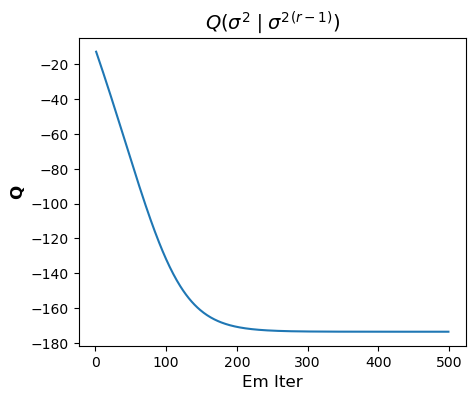

In [157]:
# Gaussian LL
fig, ax = plt.subplots(figsize=(5,4))
iters = np.arange(1,R) 
ax.plot(iters, np.array(Qs))
# ax.axvline(0.5, color='k')
ax.set_xlabel('Em Iter',fontsize=12)
ax.set_title('$Q(\\sigma^2 \mid {\\sigma^2}^{(r-1)})$', fontweight='bold',fontsize=14)
ax.set_ylabel('Q', fontweight='bold', fontsize=12)

In [106]:
R = 100
track = results['track']
CDLLs = []
for r in range(R):
    # sigma2_r = track['sigma2']
    x_ests_r = track['x_ests'][:,r]
    x_sm_r = track['x_sm'][:,r]
    CDLLfunc = compute_CDLL_idlink(x_ests_r, ns, mu, sigma2s)
    CDLLs.append(CDLLfunc)

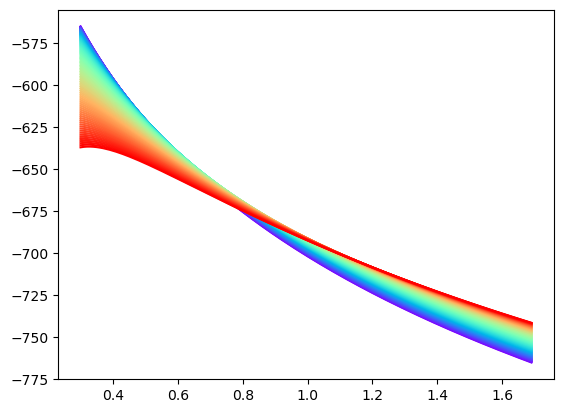

In [107]:
color = plt.cm.rainbow(np.linspace(0, 1, R))
for r in range(100):
    plt.plot(sigma2s, CDLLs[r], color=color[r])

In [17]:
R = 100
sigma2s = np.arange(0.3, 1.7, 0.01)
track = results['track']
Qs = []
for r in range(R):
    # sigma2_r = track['sigma2']
    x_ests_r = track['x_ests'][:,r]
    x_sm_r = track['x_sm'][:,r]
    Qfunc = compute_Q(x_ests_r, x_sm_r, mu, sigma2s)
    Qs.append(Qfunc)

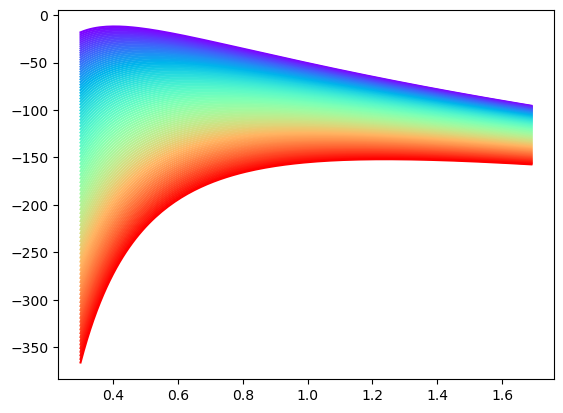

In [18]:
color = plt.cm.rainbow(np.linspace(0, 1, R))
for r in range(100):
    plt.plot(sigma2s, Qs[r], color=color[r])

In [78]:
x_sm = x_ests**2 + x_var_ests

In [84]:
compute_Q(x_ests, x_sm, mu, 0.5)

-15.726708255877782

In [85]:
test = compute_Q(x_ests, x_sm, mu, sigma2s)

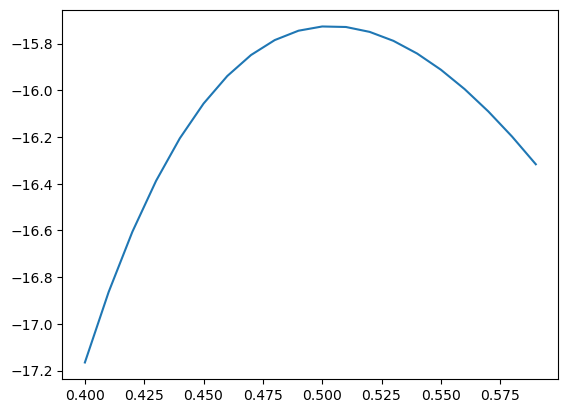

In [88]:
plt.plot(sigma2s, test)

In [82]:
for s in range

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59])

In [ ]:
def plot_Q(Ex, Ex2, mu, sigma2_range):


In [76]:
x_ests.size

100

In [71]:
def m_step_idlink(x_ests, x_var_ests, mu, L):
    Ex = x_ests
    Ex2 = x_ests**2 + x_var_ests

    sig2_est = (1/L)*(Ex2 - 2*mu*Ex + mu**2).sum()
    return sig2_est

In [72]:
test_update = m_step_idlink(x_ests, x_var_ests, mu, L_use)

In [73]:
test_update

0.5038406728387504

In [100]:
sig2

0.5

In [ ]:
if self.optim_type == "Newton":
    Result = op.minimize(fun=cost_func_optim, x0=init,
                    jac=cost_grad_optim, hess=cost_hess_optim, method='Newton-CG',
                    options={'maxiter':max_iter, 'disp':False})
elif self.optim_type == "BFGS": 
    Result = op.minimize(fun=cost_func_optim, x0=init,
                    jac=cost_grad_optim, method='BFGS',
                    options={'maxiter':max_iter, 'disp':False})

In [ ]:
ns_idlink = np.random.poisson(xs)
ns_explink = np.random.poisson(np.exp(xs))

(-1.0, 100.0)

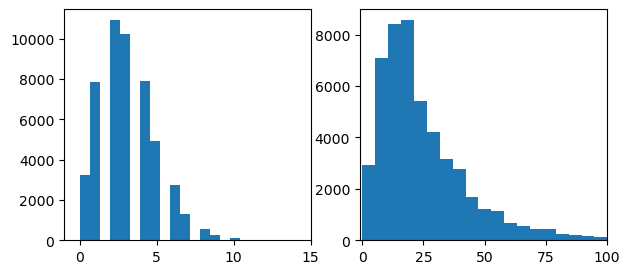

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(7,3))
ax[0].hist(n_idlink, bins=20);
ax[1].hist(n_explink, bins=100);
ax[0].set_xlim([-1,15])
ax[1].set_xlim([-1,100])

In [ ]:
# so - need to choose mu/sigma2 depending on link function, which we already knew

In [ ]:
def get_optim_funcs_idlink(n, mu, sig2):
    def cost_func(x):
        cost = n*np.log(x) - x - ( (x-mu)**2 / (2*sig2) )
        return -cost

    def cost_grad(x):
        grad = (n/x) - 1 - ( (x-mu) / (sig2) )
        return -grad


    def cost_hess(x):
        hess = -(n/(x**2)) - (1/sig2)
        return -hess

    return cost_func, cost_grad, cost_hess


def fisher_idlink(x, n, sig2):
    hess = -(n/(x**2)) - (1/sig2)
    return hess


In [ ]:
l = 0

In [ ]:
ns_idlink = ns

In [ ]:
L_use = 100
x_ests = np.zeros(L_use)
for l in range(L_use):
    cost_func, cost_grad, cost_hess = get_optim_funcs_idlink(ns_idlink[l], mu, sigma2)
    import scipy.optimize as op
    max_iter = 1000
    init = np.array([1])
    Result = op.minimize(fun=cost_func, x0=init,
                jac=cost_grad, hess=cost_hess, method='Newton-CG',
                options={'maxiter':max_iter, 'disp':False})
    x_ests[l] = Result.x[0]

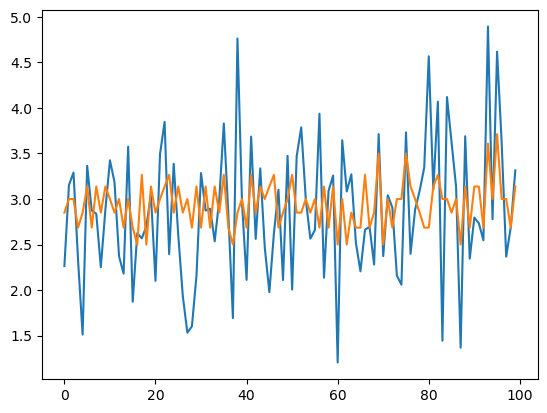

In [ ]:
plt.plot(xs[:L_use])
plt.plot(x_ests[:L_use])

In [ ]:
x_ests_fisher = fisher_idlink(x_ests, ns_idlink[:L_use], sigma2)
x_var_ests = -1/x_ests_fisher

In [ ]:
def e_step(self, max_iter=100):

    cost_func_optim = self.cost_func()
    cost_grad_optim = self.cost_grad()
    cost_hess_optim = self.cost_hess()

    # init = np.zeros(self.num_J_vars*self.K)
    init = np.zeros(self.num_J_vars*self.K)

    if self.optim_type == "Newton":
        Result = op.minimize(fun=cost_func_optim, x0=init,
                        jac=cost_grad_optim, hess=cost_hess_optim, method='Newton-CG',
                        options={'maxiter':max_iter, 'disp':False})
    elif self.optim_type == "BFGS": 
        Result = op.minimize(fun=cost_func_optim, x0=init,
                        jac=cost_grad_optim, method='BFGS',
                        options={'maxiter':max_iter, 'disp':False})
    else:
        raise NotImplementedError

    mu = Result.x
    # return mu
    Ups_inv = self.compute_fisher_info(mu)
    diag_Ups_inv = np.diag(Ups_inv)
    Ups = -1/diag_Ups_inv
    return mu, Ups_inv

In [32]:
xs.shape

(50000,)

In [ ]:
class SpikeTrial(ABC):
    def __init__(self, data):
        self.data = data

    @abstractmethod
    def cost_func(self, v, W):
        pass

    @abstractmethod
    def cost_grad(self, v, W):
        pass